INFO:tensorflow:Summary name WITS Cost is illegal; using WITS_Cost instead.
step: 0, value: 0.458575546741
step: 10, value: 7.70150327682
step: 20, value: 5.16441059113
step: 30, value: 2.26462054253
step: 40, value: 5.2215385437
step: 50, value: 7.15404891968
step: 60, value: 3.32982802391
step: 70, value: 0.347824960947
step: 80, value: 0.668698847294
step: 90, value: 0.537961304188
step: 100, value: 6.37320041656
step: 110, value: 4.50934076309
step: 120, value: 3.62012505531
step: 130, value: 3.03780984879
step: 140, value: 0.180556803942
step: 150, value: 3.80522441864
step: 160, value: 4.9128036499
step: 170, value: 1.43747520447
step: 180, value: 4.73184490204
step: 190, value: 2.90959000587
step: 200, value: 5.5265288353
step: 210, value: 1.17520618439
step: 220, value: 3.82522368431
step: 230, value: 1.10761749744
step: 240, value: 4.11064243317
step: 250, value: 1.7804775238
step: 260, value: 0.755698621273
step: 270, value: 2.29256892204
step: 280, value: 1.77971446514
step:

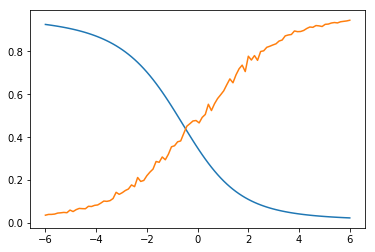

In [1]:
import tensorflow as tf
import numpy as np
import uuid
import matplotlib.pyplot as plt

# np.random.seed(2018)

m = 1 # dimension
k_sq = 0.5
learning_rate = 0.01
epochs = 10000
batch_size = 100
x_stddev = 3
activation_fn_1 = tf.nn.sigmoid
activation_fn = tf.nn.relu
num_units_1 = 150
num_units_2 = 30
decay = 1 - 1e-10

test_averaging = 100

# Allow a batch of values to work
x0 = tf.placeholder(tf.float32, [None, m])
z = tf.placeholder(tf.float32, [None, m])

l1 = tf.layers.dense(
  x0, num_units_1, activation=activation_fn_1, use_bias=True)
l2 = tf.layers.dense(
  l1, m, activation=activation_fn_1, use_bias=True)

u1 = l2
u1_cost = (tf.norm(u1)**2) / batch_size

# The observed value for the second controller is the original controlled with noise
x1 = x0 + u1
y1 = x1 + z

l3 = tf.layers.dense(
  y1, num_units_2, activation=activation_fn, use_bias=True)
l4 = tf.layers.dense(
  l3, m, activation=activation_fn, use_bias=True)

u2 = -l4
x2 = x1 + u2

u2_cost = (tf.norm(x2) ** 2) / batch_size
wits_cost = (k_sq * u1_cost) + u2_cost

adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])

optimizer = tf.train.GradientDescentOptimizer(
  learning_rate=adaptive_learning_rate).minimize(wits_cost)

init_op = tf.global_variables_initializer()

tf.summary.scalar("WITS Cost", wits_cost)
merged_summary_op = tf.summary.merge_all()

with tf.Session() as sess:
  sess.run(init_op)
  uniq_id = "/tmp/tensorboard-layers-api/" + uuid.uuid1().__str__()[:6]
  summary_writer = tf.summary.FileWriter(uniq_id, graph=tf.get_default_graph())
  x_train = np.random.normal(size=epochs * batch_size * m, scale=x_stddev)

  # Train for some epochs
  for step in range(epochs):
    x_batch = x_train[step: step + (batch_size * m)].reshape((batch_size, m))

    # Noise has variance 1
    z_batch = np.random.normal(size=(batch_size, m), scale=1)

    _, val, summary = sess.run(
      [optimizer, wits_cost, merged_summary_op],
      feed_dict={x0: x_batch, z: z_batch,
                 adaptive_learning_rate: learning_rate * (decay**step)})

    if step % 10 == 0:
      print("step: {}, value: {}".format(step, val))
      summary_writer.add_summary(summary, step)

  # Test over a continuous range of X
  x0_test = np.linspace(-2*x_stddev, 2*x_stddev, num=100)
  u1_test, u2_test, x1_test = np.zeros((1, 100)), np.zeros((1, 100)), np.zeros(
    (1, 100))

  for i in range(100):
    u1t, u2t, x1t = 0, 0, 0
    for _ in range(test_averaging):
      u1tmp, u2tmp, x1tmp = sess.run(
        [u1, u2, x1],
        feed_dict={x0: x0_test[i].reshape((1, 1)), z: np.random.normal(
          size=(1, 1), scale=1)})

      u1t += u1tmp
      u2t += u2tmp
      x1t += x1tmp

    u1_test[0, i] = u1t / test_averaging
    u2_test[0, i] = -u2t / test_averaging
    x1_test[0, i] = x1t / test_averaging

l1, = plt.plot(x0_test, u1_test[0], label="U1 Test")
l3, = plt.plot(x0_test, u2_test[0], label="U2 Test")
plt.legend(handles=[l1, l3])
plt.title("{} Unit NN With Activation Fn {}".format(
  str(num_units_1), str(activation_fn)))
plt.savefig("figure_u_1.png")

plt.clf()
l2, = plt.plot(x0_test, x1_test[0], label="X1 Test")
plt.title("{} Unit NN With Activation Fn {}".format(
  str(num_units_1), str(activation_fn)))
plt.legend(handles=[l2])
plt.savefig("figure_x_1.png")